**Домашнее задание**

Классификация изображений: Cats vs Dogs  
Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по ссылке. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.4.1
True


## Функции загрузки данных

Задание выпонено в Google Colab.

Подключим Google Диск к Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подключим ImageDataGenerator для train-выборки, чтобы можно было использовать встроенные возможностей по аугментации. Также предварительно на диске созданы отдельные поддиректории для классов и файлы размещены соответствующим образом. Для test-выборки аугментация не нужна, кроме того, нужен порядок файлов, поэтому воспользуемся самописным генератором.

In [ ]:
import re
import os
from random import shuffle
from glob import glob


IMG_SIZE = (224, 224)  # размер входного изображения сети


# сортировка для удобства
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
def natural_sorted(lst):
  return sorted(lst, key=natural_keys)

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])



base_dir = '/content/drive/MyDrive/Colab Notebooks/001'

# загрузим train-выборку и разделим ее на обучаемую и валидационную части
seed = 1337
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.02, preprocessing_function=vgg16.preprocess_input)
train = train_generator.flow_from_directory(base_dir + "/data-real/train-generator", target_size=IMG_SIZE, class_mode='binary', subset='training', seed=seed)
val = train_generator.flow_from_directory(base_dir + "/data-real/train-generator", target_size=IMG_SIZE, class_mode='binary', subset='validation', seed=seed)

# загрузим частичную test-выборку и запишем правильные ответы на предсказания
test_files_mini = natural_sorted(glob(base_dir + "/data-real/test-mini/*.jpg"))
y_test_files_mini = np.array([1., 1., 1., 1., 1., 0., 0., 1., 1., 0.])

# загрузим список файлов test-выборки и отсортируем
test_files = natural_sorted(glob(base_dir + "/data-real/test/sub/*.jpg"))


Found 24500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## Загружаем предобученную модель

In [ ]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

## Добавляем полносвязный слой

Добавим батч-нормализацию после последнего слоя vgg16, выпрямим в одномерный вектор и добавим полносвязный слой.

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Компилируем модель и запускаем обучение

В качестве оптимизатора выберем обычный SGD, как ни странно, в данной задаче он показал себя лучше, чем Adam и NAdam.

In [ ]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [ ]:
# запускаем процесс обучения
model.fit(train,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,          # число эпох обучения
          validation_data=val)

Epoch 1/100
10/10 [==============================] - 11s 1s/step - loss: 0.4691 - accuracy: 0.7542 - val_loss: 0.3191 - val_accuracy: 0.9220
Epoch 2/100
10/10 [==============================] - 10s 1s/step - loss: 0.1284 - accuracy: 0.9491 - val_loss: 0.2222 - val_accuracy: 0.9320
Epoch 3/100
10/10 [==============================] - 11s 1s/step - loss: 0.1173 - accuracy: 0.9390 - val_loss: 0.1738 - val_accuracy: 0.9500
Epoch 4/100
10/10 [==============================] - 11s 1s/step - loss: 0.0883 - accuracy: 0.9714 - val_loss: 0.1487 - val_accuracy: 0.9540
Epoch 5/100
10/10 [==============================] - 9s 1s/step - loss: 0.0853 - accuracy: 0.9714 - val_loss: 0.1300 - val_accuracy: 0.9540
Epoch 6/100
10/10 [==============================] - 10s 1s/step - loss: 0.0736 - accuracy: 0.9716 - val_loss: 0.1403 - val_accuracy: 0.9540
Epoch 7/100
10/10 [==============================] - 9s 974ms/step - loss: 0.0529 - accuracy: 0.9775 - val_loss: 0.1435 - val_accuracy: 0.9540
Epoch 8/100


## Сохраним модель

Создадим директорию для сохранения результатов тестов: веса модели и предсказания.

In [ ]:
import time

p_dir = base_dir + "/tests/" + str(int(time.time()))
os.mkdir(p_dir, 0o755)
p_dir

'/content/drive/MyDrive/Colab Notebooks/001/tests/1615828571'

In [ ]:
model.save(p_dir + '/cats-dogs-vgg16.hdf5')

## Предсказания на минимальной проверочной выборке

Выполним предсказания частичной test-выборке.

In [ ]:
test_pred_mini = model.predict(predict_generator(test_files_mini), steps=len(test_files_mini))

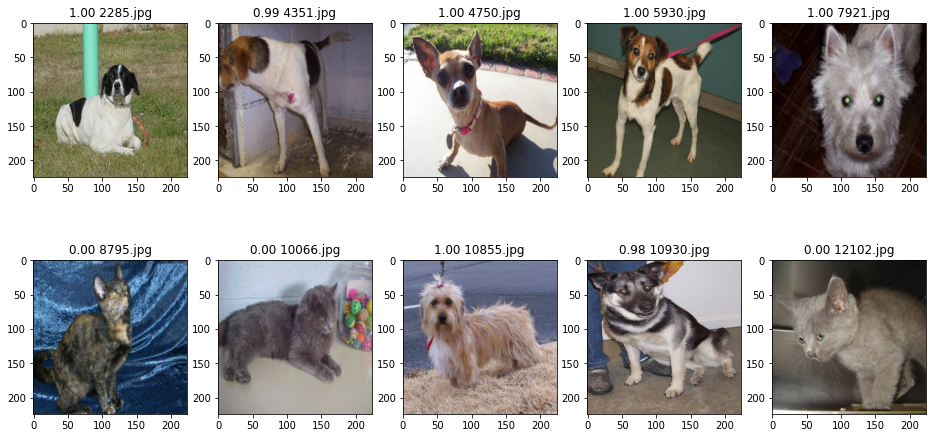

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

cnt = 10
per_line = 5
lines = cnt // per_line

fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files_mini[:cnt], test_pred_mini[:cnt]), 1):
    subplot = fig.add_subplot(lines, per_line, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

Выглядит довольно неплохо. Но давайте еще и метрики посмотрим на этой очень малой тестовой выборке.

In [ ]:
from sklearn.metrics import log_loss, accuracy_score

y_pred = np.concatenate(test_pred_mini).astype("float64")
print(f"loss: {log_loss(y_test_files_mini, y_pred)}, accuracy: {accuracy_score(y_test_files_mini, np.round(test_pred_mini))}.")

loss: 0.002913565390768476, accuracy: 1.0.


## Предсказания на полной проверочной выборке

In [ ]:
test_pred = model.predict(predict_generator(test_files), steps=len(test_files))

## Готовим данные для отправки

In [ ]:
with open(p_dir + '/submition.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

## Результат оценки работы модели на test-выборке на Kaggle.

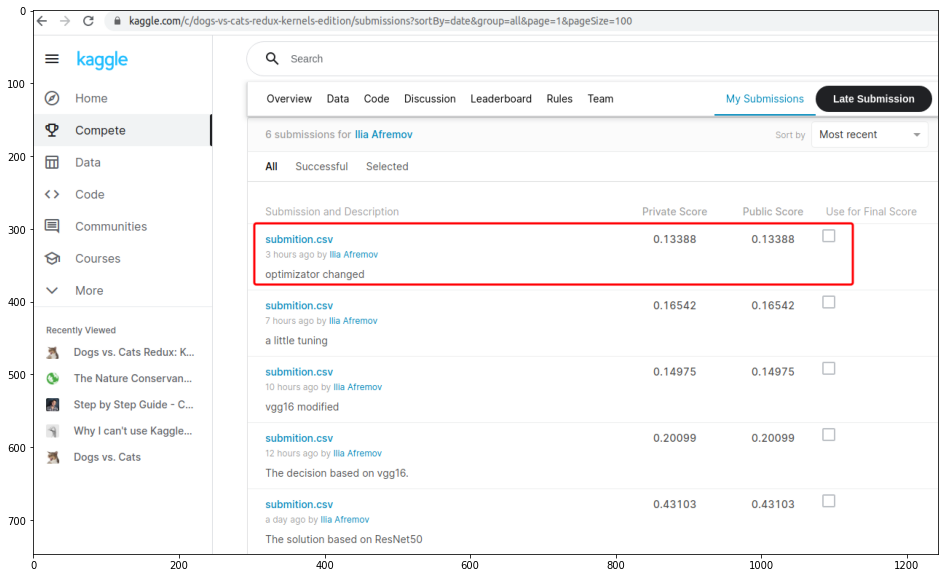

In [ ]:
img_cv = cv2.imread(base_dir + "/kaggle-loss.png")
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 10))
plt.imshow(img_rgb)
plt.show()